Приведем подробные инструкции для решения поставленной задачи.

Сначала обновим и установим необходимые модули.

In [8]:
!pip install --upgrade pip
!pip install imutils
!pip install opencv-python
!pip install --upgrade scikit-learn==0.23.0

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


Подключение базовых библиотек для обработки изображений

In [9]:
from IPython.display import Image
from imutils import paths
import numpy as np
import cv2
import os

Для работы с изображениями, найдем их гистограммы — характеристики распределения интенсивности изображения. Для этого можно воспользоваться следующим методом.

In [10]:
def extract_histogram(image, bins=(8, 8, 8)):
    hist = cv2.calcHist([image], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

Считаем изображения из корневой папки train и вычислим гистограмму каждого изображения. Кроме того, отделим метку каждого изображения. Обработка большого числа изображений в облачных сервисах занимает длительное время (1-5 минут).

In [14]:
imagePaths = sorted(list(paths.list_images('train')))
trainData = []
labels = []

for (i, imagePath) in enumerate(imagePaths):
    image = cv2.imread(imagePath, 1)
    label = imagePath.split(os.path.sep)[-1].split(".")[0]
    hist = extract_histogram(image)
    trainData.append(hist)
    labels.append(label)

labels

[]

Преобразуем метки в удобный формат 0 и 1. Cat заменяем на 1, Dog на 0.

In [12]:
Y = [1 if x == 'cat' else 0 for x in labels]

In [13]:
print(Y[0])
Image(filename=imagePaths[0])

IndexError: list index out of range

Видно, что классом 1 у нас занумерованы коты (кошки).

Обучаем первый базовый классификатор - бэггинг деревьев принятия решений

In [9]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', #критерий разделения
                              min_samples_leaf=20, #минимальное число объектов в листе
                              max_leaf_nodes=30, #максимальное число листьев
                              random_state=2020)
bagging = BaggingClassifier(tree, #базовый алгоритм
                            n_estimators=10, #количество деревьев
                            random_state=2020)
bagging.fit(trainData, Y)

BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                        max_leaf_nodes=30,
                                                        min_samples_leaf=20,
                                                        random_state=2020),
                  random_state=2020)

Теперь обучим модель почти-разделяющий гиперплосоксти.

In [10]:
from sklearn.svm import LinearSVC

svm = LinearSVC(random_state = 51, C = 1)
svm.fit(trainData, Y)

LinearSVC(C=1, random_state=51)

И наконец обучаем третий базовый алгоритм — случайный лес

In [11]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=10, #количество деревьев
                             criterion='entropy', #критерий разделения
                              min_samples_leaf=20, #минимальное число объектов в листе
                              max_leaf_nodes=30, #максимальное число листьев
                              random_state=2020)
forest.fit(trainData, Y)

RandomForestClassifier(criterion='entropy', max_leaf_nodes=30,
                       min_samples_leaf=20, n_estimators=10, random_state=2020)

Задаем в качестве решающего метаалгоритма логистическую регрессию:

In [12]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='lbfgs', random_state=2020)

Обучаем метаалгоритм

In [13]:
from sklearn.ensemble import StackingClassifier

base_estimators = [('SVM', svm), ('Bagging DT', bagging), ('DecisionForest', forest)]
sclf = StackingClassifier(estimators=base_estimators, final_estimator=lr, cv=2)
sclf.fit(trainData, Y)

StackingClassifier(cv=2,
                   estimators=[('SVM', LinearSVC(C=1, random_state=51)),
                               ('Bagging DT',
                                BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                                                        max_leaf_nodes=30,
                                                                                        min_samples_leaf=20,
                                                                                        random_state=2020),
                                                  random_state=2020)),
                               ('DecisionForest',
                                RandomForestClassifier(criterion='entropy',
                                                       max_leaf_nodes=30,
                                                       min_samples_leaf=20,
                                                       n_estimators=10,
    

Оценка метамодели. Доля правильной классификации (Accuracy):

In [14]:
sclf.score(trainData, Y)

0.83

Вычислим предсказания для объекта из папки test

In [15]:
singleImage = cv2.imread('test/dog.1041.jpg')
histt = extract_histogram(singleImage)
histt2 = histt.reshape(1, -1)
prediction = sclf.predict(histt2)

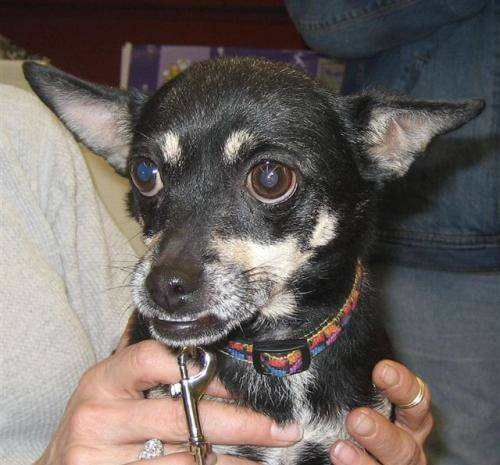

In [16]:
Image(filename='test/dog.1041.jpg')

In [17]:
prediction

array([0])

In [18]:
sclf.predict_proba(histt2)

array([[0.61690765, 0.38309235]])

Видно, что построенный классификатор успешно справился с заданием.